# Industrial Example: MDP Basics with Inventory Control




## Testing Env.

In [1]:
import numpy as np


p_sale = 0.7 # Probability of a sale in one step
n_steps = 100 # Number of steps to run experiment for
np.random.seed(42)


## Actions and Potential Strategies

Define the actions of the agent: it can either restock, or do nothing. 

Provide some simple strategies in this class: always buy, randomly buy and only buy when there is nothing left in stock.

> Note that this is a little contrived. In general, the actions and strategy are completely decoupled. I’m keeping them here for simplicity.



In [3]:
from enum import Enum

class Action(Enum):
    NONE = 0
    RESTOCK = 1

    @staticmethod
    def keep_buying_action(current_state) -> Enum:
        if current_state == 2:
            return Action.NONE
        else:
            return Action.RESTOCK
        
    @staticmethod
    def random_action(current_state) -> Enum:
        if current_state == 2:
            return Action.NONE
        if np.random.randint(len(Action)) == 0:
            return Action.NONE
        else:
            return Action.RESTOCK

    @staticmethod
    def zero_action(current_state) -> Enum:
        if current_state == 0:
            return Action.RESTOCK
        else:
            return Action.NONE
        
print("There are {} actions.".format(len(Action)))


There are 2 actions.


## Transition Matrix
It defines how the environment changes state

In [6]:
# represents the following states:
# state 0: out of stock
# state 1
# state 2: full

# columns: next state
# rows: current state
# cell: transition probability

transition_matrix = [

    # No Action
    [
        [1, 0, 0],
        [p_sale, 1 - p_sale, 0],
        [0, p_sale, 1 - p_sale]
    ],

    # Restock
    [
        [p_sale, 1 - p_sale, 0],
        [0, p_sale, 1 - p_sale]
    ]
]

## Reward Matrix
It tells the env how to reward the agent based upon certain actions and states.

In [4]:
# aget gets reward after selling

reward_matrix = [
    # No action
    [
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
    ],
    # Restock
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ],
]

# Experiment 1: The Environment


In [7]:
def environment(current_state: int, action: int) -> (int, int):
    
    # Get the transition probabilities to each new state
    current_transition_probs = transition_matrix[action.value][current_state]

    # Use the transition probabilitis to transition to a new state
    # Recall that the sale is a stochastic variable
    next_state = np.random.choice(
        a=[0, 1, 2],
        p=current_transition_probs        
    )

    # Get the reward for the new state (was there a sale?)
    reward = reward_matrix[action.value][current_state][next_state]
    return (next_state, reward)

current_state = 1
action = Action.RESTOCK     # this is usually chosen by a strategy/policy
for i in range(10):
    next_state, reward = environment(current_state, action) # Environment interface
    print(f"trial {i}: s={current_state}, a={action}, s'={next_state}, r={reward}")

trial 0: s=1, a=Action.RESTOCK, s'=1, r=1
trial 1: s=1, a=Action.RESTOCK, s'=2, r=0
trial 2: s=1, a=Action.RESTOCK, s'=2, r=0
trial 3: s=1, a=Action.RESTOCK, s'=1, r=1
trial 4: s=1, a=Action.RESTOCK, s'=1, r=1
trial 5: s=1, a=Action.RESTOCK, s'=1, r=1
trial 6: s=1, a=Action.RESTOCK, s'=1, r=1
trial 7: s=1, a=Action.RESTOCK, s'=2, r=0
trial 8: s=1, a=Action.RESTOCK, s'=1, r=1
trial 9: s=1, a=Action.RESTOCK, s'=2, r=0


# Experiment 2: Testing Different Restocking Strategies


In [8]:
import pandas as pd

# The different strategies
strategies = [("Keep Buying", Action.keep_buying_action),
            ("Upon Zero", Action.zero_action), ("Random", Action.random_action)]
result = [] # Results buffer

for (policy_name, action_getter) in strategies:
    np.random.seed(42) # This is really important, otherwise different strategies will experience sales
    reward_history = [] # Reward buffer
    current_state = 2 # Initial state
    total_reward = 0
    for i in range(n_steps):
        reward_history.append(total_reward)
        action = action_getter(current_state) # Get new action for strategy
        next_state, reward = environment(current_state, action) # Environment interface
        print("Moving from state {} to state {} after action {}. We received the reward {}."
              .format(current_state, next_state, action.name, reward))
        total_reward += reward
        current_state = next_state # Set next state to current state and repeat
    print("The total reward was {}.".format(total_reward))

    # Pandas/plotting stuff
    series = pd.Series(
        reward_history,
        index=range(n_steps),
        name="{} ({})".format(policy_name, total_reward / n_steps))
    result.append(series)
df = pd.concat(result, axis=1)


Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the r

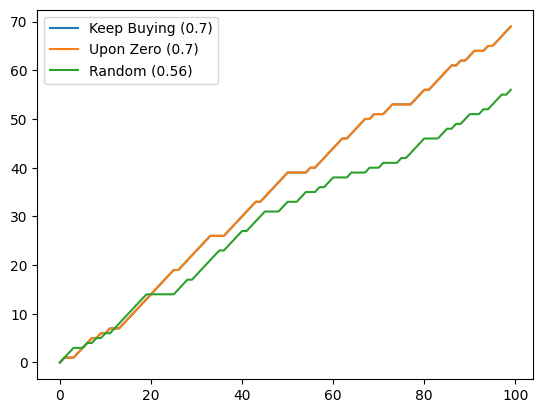

In [9]:
df.plot();

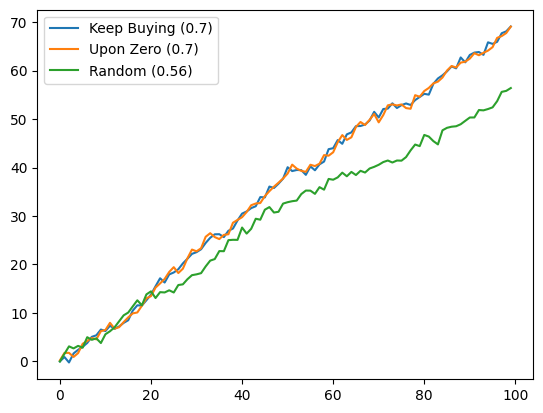

In [10]:
# Fix: the restock and just in time curves are overlapping
(df + np.random.normal(size=df.shape)*0.5).plot();


# Experiment 3: Random Seeds

same previous code but w/o settomg a fixed seeed

In [12]:
import pandas as pd

# The different strategies
strategies = [("Keep Buying", Action.keep_buying_action),
            ("Upon Zero", Action.zero_action), ("Random", Action.random_action)]
result = [] # Results buffer

for (policy_name, action_getter) in strategies:
    # np.random.seed(42) # Commenting this line out!!!
    reward_history = [] # Reward buffer
    current_state = 2 # Initial state
    total_reward = 0
    for i in range(n_steps):
        reward_history.append(total_reward)
        action = action_getter(current_state) # Get new action for strategy
        next_state, reward = environment(current_state, action) # Environment interface
        print("Moving from state {} to state {} after action {}. We received the reward {}."
              .format(current_state, next_state, action.name, reward))
        total_reward += reward
        current_state = next_state # Set next state to current state and repeat
    print("The total reward was {}.".format(total_reward))

    # Pandas/plotting stuff
    series = pd.Series(
        reward_history,
        index=range(n_steps),
        name="{} ({})".format(policy_name, total_reward / n_steps))
    result.append(series)
df = pd.concat(result, axis=1)


Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received th

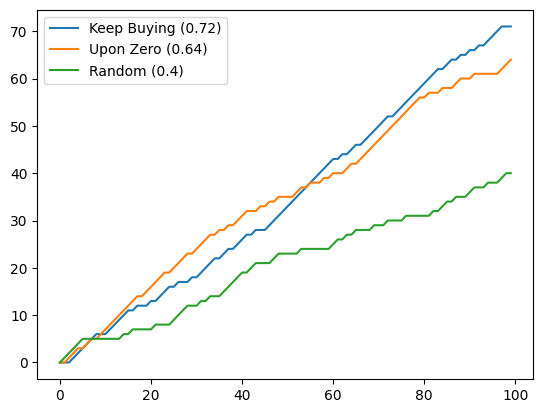

In [13]:
df.plot();
